In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Lambda, Dropout, BatchNormalization
from keras import regularizers, losses
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from tensorflow.keras.losses import MeanSquaredError
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

import os

In [2]:
# Utility functions
def pclip(p):
    """Clip recall probability to avoid numerical issues."""
    return p.clip(0.0001, 0.9999)


def hclip(h):
    min_half_life = 15.0 / (24 * 60)  # 15 minutes in days
    max_half_life = 274.0   
    """Clip half-life to a reasonable range."""
    return h.clip(min_half_life, max_half_life)


In [3]:
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
dff = pd.merge(pd.merge(df_words, df, on = 'lexeme_id', how='inner'), df_users, on = ['user_id', 'lang_combination'], how='inner')

In [4]:
dff.head()

,lexeme_id,gender,def,tense,POS,person,number,word,word_len,tags_list,...,ui_language,history_seen,history_correct,session_seen,session_correct,h_recall,lang_combination,avg_delta,std_delta,avg_h_recall
0,76390c1350a8dac31186187e2fe1e178,NaN,NaN,pri,vblex,p3,sg,lernt,5,"['vblex', 'pri', 'p3', 'sg']",...,en,6,4,2,2,0.666667,en-de,6.245869e+06,1.175043e+07,0.884367
1,76390c1350a8dac31186187e2fe1e178,NaN,NaN,pri,vblex,p3,sg,lernt,5,"['vblex', 'pri', 'p3', 'sg']",...,en,8,6,6,6,0.750000,en-de,6.245869e+06,1.175043e+07,0.884367
2,76390c1350a8dac31186187e2fe1e178,NaN,NaN,pri,vblex,p3,sg,lernt,5,"['vblex', 'pri', 'p3', 'sg']",...,en,14,12,1,0,0.857143,en-de,6.245869e+06,1.175043e+07,0.884367
3,76390c1350a8dac31186187e2fe1e178,NaN,NaN,pri,vblex,p3,sg,lernt,5,"['vblex', 'pri', 'p3', 'sg']",...,en,15,12,1,1,0.800000,en-de,6.245869e+06,1.175043e+07,0.884367
4,76390c1350a8dac31186187e2fe1e178,NaN,NaN,pri,vblex,p3,sg,lernt,5,"['vblex', 'pri', 'p3', 'sg']",...,en,16,13,2,1,0.812500,en-de,6.245869e+06,1.175043e+07,0.884367


In [5]:
# cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'ui_language', 'learning_language', 'h_recall']

# - LEX - U features
# cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'ui_language', 'learning_language', 'h_recall', 'avg_delta', 'std_delta', 'avg_h_recall', 'tags_list',
#                 'gender', 'SUBTLEX', 'def', 'tense', 'POS', 'person', 'number', 'word_len']


# - LEX
cols_to_drop=['tags_list', 'word_len', 'SUBTLEX', 'gender', 'def', 'tense', 'POS', 'person', 'number', 'learning_language', 'timestamp', 'user_id', 'word',
              'ui_language', 'h_recall', 'lexeme_id']


dff.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# dff.dropna(inplace=True)

In [6]:
dff.head()

,p_recall,delta,history_seen,history_correct,session_seen,session_correct,lang_combination,avg_delta,std_delta,avg_h_recall
0,1.0,27649635,6,4,2,2,en-de,6.245869e+06,1.175043e+07,0.884367
1,1.0,5963,8,6,6,6,en-de,6.245869e+06,1.175043e+07,0.884367
2,0.0,253,14,12,1,0,en-de,6.245869e+06,1.175043e+07,0.884367
3,1.0,65,15,12,1,1,en-de,6.245869e+06,1.175043e+07,0.884367
4,0.5,27,16,13,2,1,en-de,6.245869e+06,1.175043e+07,0.884367


In [11]:
# columns transformation
# dff['delta'] = np.log2(dff['delta']/(60*60*24)) # convert time delta to days
dff['avg_delta'] = np.log2(dff['avg_delta']/(60*60*24)) 
dff['std_delta'] = np.log2(dff['std_delta']/(60*60*24)+1e-10)
# dff['p_recall'] = pclip(dff['p_recall'])
# dff['history_seen'] = np.log2((1+dff['history_seen']))
# dff['history_correct'] = np.log2(1+dff['history_correct'])

# dff['history_wrong'] = np.log2(1+(dff['history_seen'] - dff['history_correct']))
# dff['SUBTLEX'] = np.log2(dff['SUBTLEX'])

In [12]:
# Store each tag as column, replace NaN values with a placeholder for categorical columns
categorical_cols = dff.select_dtypes(include=['object']).columns.tolist()
dff[categorical_cols] = dff[categorical_cols].fillna('missing')
# dff.drop(columns=['tags_list'], inplace=True)


# tag_counts = dff['tags_list'].value_counts()
# rare_threshold = 1000
# dff['tags_list'] = dff['tags_list'].apply(lambda x: x if tag_counts[x] > rare_threshold else 'rare')
# dff.drop(columns=['POS', 'person', 'number', 'gender', 'tense', 'def'], inplace=True, errors='ignore')


In [13]:
dff.head()

,p_recall,delta,history_seen,history_correct,session_seen,session_correct,lang_combination,avg_delta,std_delta,avg_h_recall
0,0.9999,8.322013,2.807355,2.321928,2,2,en-de,6.175727,7.087467,0.884367
1,0.9999,-3.856921,3.169925,2.807355,6,6,en-de,6.175727,7.087467,0.884367
2,0.0001,-8.415750,3.906891,3.700440,1,0,en-de,6.175727,7.087467,0.884367
3,0.9999,-10.376376,4.000000,3.700440,1,1,en-de,6.175727,7.087467,0.884367
4,0.5000,-11.643856,4.087463,3.807355,2,1,en-de,6.175727,7.087467,0.884367


In [14]:
def scale_dataset(df):
    categorical_features = df.select_dtypes(include='O').columns
    numeric_features = df.select_dtypes(exclude=['O']).columns.drop(['p_recall', 'session_seen', 'session_correct'])

    scaler = MinMaxScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    return df, categorical_features, numeric_features

In [15]:
def ohe(df):
    """
    One-hot encode categorical variables
    """ 
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))
    df_encoded = pd.concat([df.select_dtypes(exclude='O'), ohe_df], axis=1)
    df_encoded.dropna(inplace=True)
    return df_encoded


dff.dropna(inplace=True)
df_final = ohe(dff)
df_final, categorical_features, numeric_features = scale_dataset(df_final)

In [16]:
# Take sample for tuning 
df_final = df_final.sample(frac=1)

In [17]:
df_final.head()

,p_recall,delta,history_seen,history_correct,session_seen,session_correct,avg_delta,std_delta,avg_h_recall,lang_combination_en-de,lang_combination_en-es,lang_combination_en-fr,lang_combination_en-it,lang_combination_en-pt,lang_combination_es-en,lang_combination_it-en,lang_combination_pt-en
5476655,0.0001,0.368334,0.166011,0.197086,1.0,0.0,0.857170,0.957643,0.834544,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11395392,0.9999,0.692489,0.073461,0.000000,3.0,3.0,0.706990,0.859059,0.847450,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12456768,0.9999,0.313192,0.125582,0.149090,1.0,1.0,0.320046,0.535678,0.870473,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6202544,0.9999,0.336266,0.073461,0.087212,1.0,1.0,0.642754,0.854842,0.909004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9656362,0.9999,0.349606,0.125582,0.149090,2.0,2.0,0.647295,0.809269,0.852896,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [18]:
def split_dataset(df):
    X = df.drop(columns='p_recall')
    y = df['p_recall']
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    
    X_test_session = X_test[['session_seen', 'session_correct']]

    X_test.drop(columns=['session_seen', 'session_correct'], inplace=True)
    X_train.drop(columns=['session_seen', 'session_correct'], inplace=True)

    return X_train, X_test, y_train, y_test, X_test_session

X_train, X_test, y_train, y_test, X_test_session = split_dataset(df_final)

In [19]:
# Train test split
def split(df, numeric_features): 
    
    X = df.drop(columns=['p_recall'])
    y = df[['p_recall']]
    
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)

    X_test_session = X_test[['session_seen', 'session_correct']]

    
    X_train_numerical = X_train[numeric_features].to_numpy()
    X_test_numerical = X_test[numeric_features].to_numpy()
    
    
    # Embeddings 
    # X_train_tags = X_train['tags_list'].to_numpy().reshape(-1,1)
    # X_train_langs = X_train['lang_combination'].to_numpy().reshape(-1,1)
    # X_test_tags = X_test['tags_list'].to_numpy().reshape(-1,1)
    # X_test_langs = X_test['lang_combination'].to_numpy().reshape(-1,1)

    
    # Embeddings 
    # return df, X_train_tags, X_train_langs, X_train_numerical, X_test_tags, X_test_langs, X_test_numerical, X_train_delta, X_test_delta, X_test, y_train, y_test, y_train_half_life, y_train_p_recall, y_test_half_life, y_test_p_recall

    # No embeddings 
    return df, X_train_numerical, X_test_numerical, y_train, y_test, X_test_session

# Embeddings 
# df, X_train_tags, X_train_langs, X_train_numerical, X_test_tags, X_test_langs, X_test_numerical, X_train_delta, X_test_delta, X_test, y_train, y_test, y_train_half_life, y_train_p_recall, y_test_half_life, y_test_p_recall = split(df_final, numeric_features)


# No embeddings
df, X_train_numerical, X_test_numerical, y_train, y_test, X_test_session = split(df_final, numeric_features)

In [20]:
# Check if shapes match

# print('X_train_tags_size', X_train_tags.shape)
# print('X_train_langs_size', X_train_langs.shape)
# print('X_train_numerical_size', X_train_numerical.shape)
# print('X_test_tags_size', X_test_tags.shape)
# print('X_test_langs_size', X_test_langs.shape)
# print('X_test_numerical_size', X_test_numerical.shape)
# print('y_train_half_life_size', y_train_half_life.shape)
# print('y_train_p_recall_size', y_train_p_recall.shape)
# print('y_test_half_life_size', y_test_half_life.size)
# print('y_test_p_recall_size', y_test_p_recall.size)

In [21]:
# Compute custom weights
# def compute_custom_weights(y, num_bins = 5): 
#     bins = np.quantile(y, np.linspace(0, 1, num_bins + 1))
#     bin_indices = np.digitize(y, bins, right=True)
#     bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)
#     bin_freqs = bin_counts / len(y)

#     # Assign inverse weights
#     bin_weights = 1 / (bin_freqs + 1e-6) 
#     sample_weights = bin_weights[bin_indices]
#     return sample_weights

# sample_weights = compute_custom_weights(y_train)

In [22]:
# Embeddings
# def emb_layers(df): 
#     len_tags = len(np.unique(df['tags_list']))
#     len_langs = len(np.unique(df['lang_combination']))
    
#     embedding_tags_size = int(min(np.ceil((len_tags)/2), 50))
#     embedding_langs_size = int(min(np.ceil((len_langs)/2), 50))
    
#     tags_input = Input(shape=(1,))  
#     langs_input = Input(shape=(1,))  
    
#     tags_embedded = Embedding(input_dim=len_tags, output_dim=embedding_tags_size)(tags_input)  
#     langs_embedded = Embedding(input_dim=len_langs, output_dim=embedding_langs_size)(langs_input)  
    
#     flattened_tags = Flatten()(tags_embedded)
#     flattened_langs = Flatten()(langs_embedded)
    
#     numerical_input = Input(shape=(len(numeric_features),)) 
#     delta_input = Input(shape=(1,))  
    
#     # Concatenate layers
#     conc_layers = [flattened_tags, flattened_langs, numerical_input]
#     conc = Concatenate()(conc_layers)
#     return conc, numerical_input, delta_input, tags_input, langs_input

# conc, numerical_input, delta_input, tags_input, langs_input = emb_layers(df)

# numerical_input = Input(shape=(len(numeric_features),)) 
# delta_input = Input(shape=(1,))

In [23]:
input_dim = X_train.shape[1]


def train_model(hidden_dim=16, l2wt=0.01, learning_rate=0.001, dropout_rate=0.5, batch_size=64):
    inputs = Input(shape=(input_dim,))
    x = Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(l2wt))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation="sigmoid", name="p_recall")(x)
    
    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse", metrics=["MAE"])
    return model

In [24]:
reg = KerasRegressor(
    model=train_model,
    verbose=0,
    epochs=10,
    batch_size=64
)

param_dist = {
    "model__hidden_dim": [8, 16, 32],
    "model__l2wt": [0.001, 0.01, 0.1],
    "model__dropout_rate": [0.3, 0.5],
    "model__learning_rate": [0.001, 0.005],
    "batch_size": [32, 64],
    "epochs": [10, 15]
}

search = RandomizedSearchCV(
    reg,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=2,
    scoring="neg_mean_squared_error"
)


search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best score:", -search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [25]:
model = train_model(hidden_dim=32, l2wt=0.001, learning_rate=0.001, dropout_rate=0.5, batch_size=64)
model.fit(X_train, y_train)
model.summary()

317462/317462 ━━━━━━━━━━━━━━━━━━━━ 93s 291us/step - MAE: 0.1709 - loss: 0.0734 


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_recall (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,797 (7.02 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 1,156 (4.52 KB)

In [26]:
# Shapes check

# print("Max tag index:", X_train_tags.max(), "Embedding input_dim:", len_tags)
# print("Max lang index:", X_train_langs.max(), "Embedding input_dim:", len_langs)

# print("Tags Input Shape:", tags_input.shape)
# print("Langs Input Shape:", langs_input.shape)
# print("Numerical Input Shape:", numerical_input.shape)

# print("Flattened tags Embedded Shape:", flattened_tags.shape)
# print("Flattened Langs Embedded Shape:", flattened_langs.shape)
# # print("Flattened Numerical Input Shape:", numerical_input.shape)

# print("X_train_tags shape:", X_train_tags.shape)    
# print("X_train_langs shape:", X_train_langs.shape)  
# print("X_train_numerical shape:", X_train_numerical.shape)  
# print("X_train_delta shape:", X_train_delta.shape)  
# print('X_test numerical shape:', X_test_numerical.shape)  # Expected: (num_samples, 178), but you have (num_samples, 176)
# print('X_test delta shape:', X_test_delta.shape)   # Ensure it matches the expected shape
# print('input df shape', df_final.shape)

# print(y_train_half_life.shape)
# print(y_train_p_recall.shape)


In [27]:
# Predict Emb
# y_pred_half_life, y_pred_p_recall  = model.predict([X_test_tags, X_test_langs, X_test_numerical, X_test_delta])


In [28]:
y_pred_p_recall  = model.predict(X_test)

79366/79366 ━━━━━━━━━━━━━━━━━━━━ 12s 147us/step


In [29]:
print('Test MAE:', mean_absolute_error(y_test, y_pred_p_recall))

Test MAE: 0.16797767353476792


In [30]:
df_results = X_test_session.copy()
df_results['p_recall'] = y_test
df_results['p_recall_pred'] = y_pred_p_recall
df_results['diff'] = df_results['p_recall'] - df_results['p_recall_pred']
df_results

,session_seen,session_correct,p_recall,p_recall_pred,diff
1146486,2.0,2.0,0.999900,0.931102,0.068798
656358,1.0,1.0,0.999900,0.906930,0.092970
11835143,1.0,1.0,0.999900,0.828197,0.171703
7667400,3.0,2.0,0.666667,0.884739,-0.218072
10933161,6.0,6.0,0.999900,0.925801,0.074099
...,...,...,...,...,...
12204562,1.0,1.0,0.999900,0.903530,0.096370
11909091,1.0,1.0,0.999900,0.904129,0.095771
4304002,1.0,0.0,0.000100,0.903559,-0.903459
1151357,1.0,1.0,0.999900,0.880653,0.119247


In [31]:
df_results.sort_values(by='diff')
df_results

,session_seen,session_correct,p_recall,p_recall_pred,diff
1146486,2.0,2.0,0.999900,0.931102,0.068798
656358,1.0,1.0,0.999900,0.906930,0.092970
11835143,1.0,1.0,0.999900,0.828197,0.171703
7667400,3.0,2.0,0.666667,0.884739,-0.218072
10933161,6.0,6.0,0.999900,0.925801,0.074099
...,...,...,...,...,...
12204562,1.0,1.0,0.999900,0.903530,0.096370
11909091,1.0,1.0,0.999900,0.904129,0.095771
4304002,1.0,0.0,0.000100,0.903559,-0.903459
1151357,1.0,1.0,0.999900,0.880653,0.119247


In [32]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df_results.describe()

,session_seen,session_correct,p_recall,p_recall_pred,diff
count,2539690.00000,2539690.00000,2539690.00000,2539690.00000,2539690.00000
mean,1.81772,1.64503,0.89680,0.89952,-0.00272
std,1.36108,1.31876,0.27023,0.02927,0.26672
min,1.00000,0.00000,0.00010,0.34782,-0.97460
25%,1.00000,1.00000,0.99990,0.88896,0.07330
50%,1.00000,1.00000,0.99990,0.90414,0.08997
75%,2.00000,2.00000,0.99990,0.91664,0.10570
max,20.00000,20.00000,0.99990,0.97727,0.63913


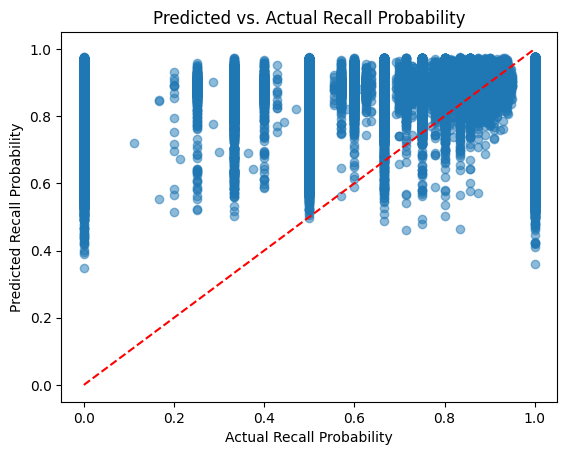

In [33]:
# Predicted vs Actual 
def out_filepath(filename):
    return os.path.normpath(os.path.join(current_dir, '../reports', filename))

    
pred_scatterplot = plt.scatter(df_results['p_recall'], df_results['p_recall_pred'], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")
pred_scatterplot.figure.savefig(out_filepath('visualizations/NeuralNetwork_predictions_scatterplot.png'))


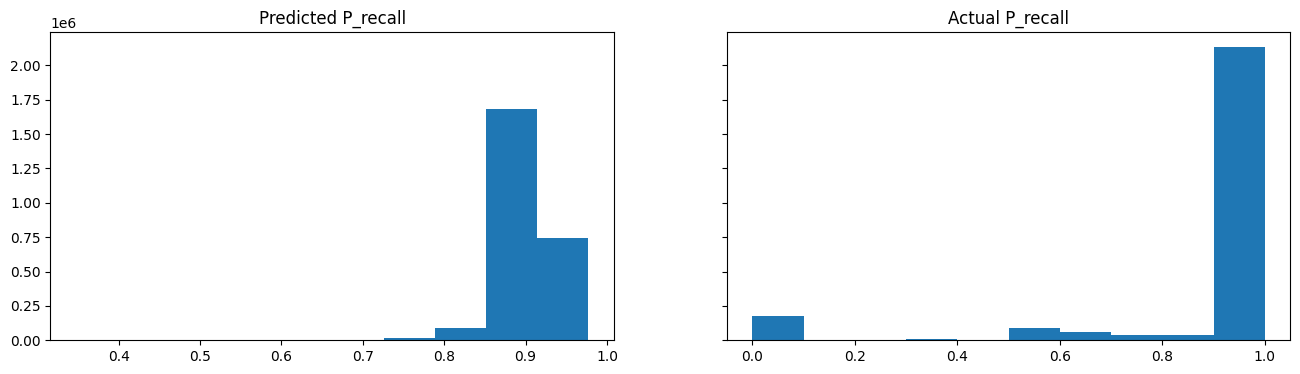

In [34]:
p_recall_histogram, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Predicted P_recall')
ax2.hist(df_results['p_recall'])
ax2.set_title('Actual P_recall')
ax1.hist(df_results['p_recall_pred'])
p_recall_histogram.set_size_inches(16, 4)

In [35]:
expanded_df = df_results.loc[df_results.index.repeat(df_results["session_seen"])].reset_index(drop=True)
expanded_df["outcome"] = np.concatenate([
    np.concatenate([np.ones(int(c)), np.zeros(int(s - c))])  # c correct, (s-c) incorrect
    for s, c in zip(df_results["session_seen"], df_results["session_correct"])
])

In [36]:


%run diagnostics.ipynb


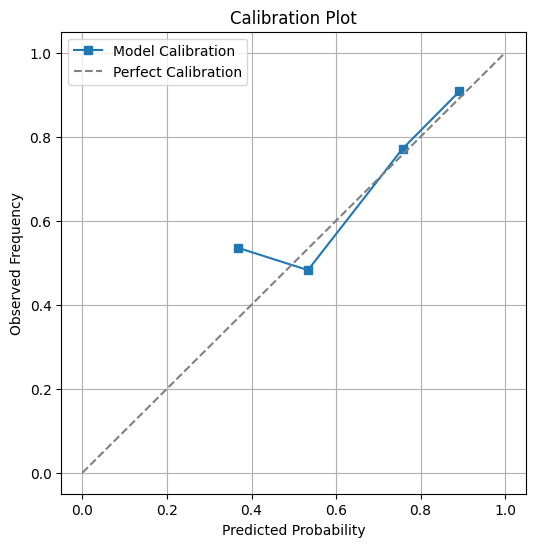

In [124]:

plot_calibration(expanded_df['outcome'], expanded_df['p_recall_pred'], 'NeuralNetwork_calibration_plot.png')

AUC Score: 0.6079


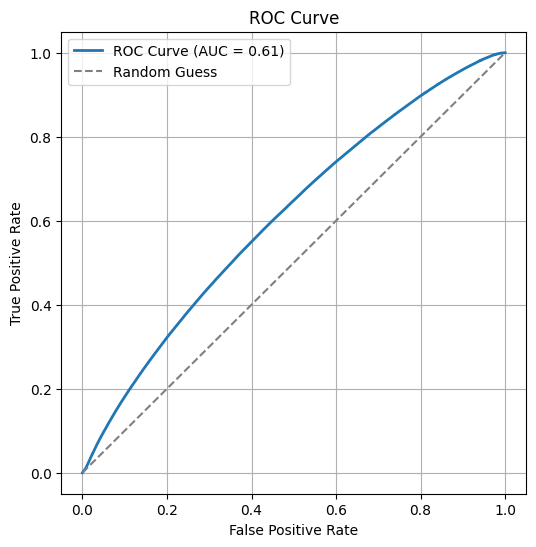

In [37]:
AUC_ROC(expanded_df['outcome'], expanded_df['p_recall_pred'], 'NeuralNetwork_ROC_plot.png')

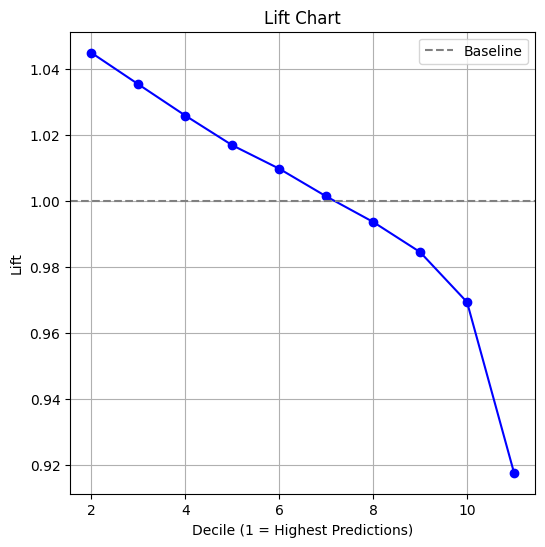

In [126]:
plot_lift(expanded_df, 'outcome', expanded_df['p_recall_pred'], 'FNN_lift_plot.png')

In [128]:
fnn_output = expanded_df.drop(columns=['session_seen', 'session_correct'])

filepath = os.path.normpath(os.path.join(current_dir, '../results/'))
fnn_output.to_csv(os.path.join(filepath, 'fnn_output.csv'), sep='\t', index=False, header=True)